# Game Analysis
Here I calculate some statistics about all the games I have played on chess.com (up to 13/06/2021).

## TOC
 - [Read Data](#Read-Data)
 - [Overview of Data](#Overview-of-Data)
 - [Pre-Processing](#Pre-Processing)
 - [Explore Data](#Explore-Data)
  - [Win Rates](#Win-Rates)
  - [Rolling Win Rate](#Rolling-Win-Rate)

In [1]:
import json
import numpy as np
import pandas as pd
import Fetcher as F
import Reader as R

## Read Data
`games.csv` was obtained using `Fetcher.fetch_every_game`.

In [2]:
df=F.__read_csv("data/games.csv")
df=df.rename(columns={"time_control":"time_limit"})

## Overview of Data

In [3]:
df.shape

(896, 10)

The dataset contains 10 fields for 896 games. However, this data has not been fully processed and many of the fields contain more than once piece of data.

In [4]:
# View of data
df.loc[0,:]

url                  https://www.chess.com/game/live/6009142163
pgn           [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...
time_limit                                                  600
end_time                                             1608417059
rated                                                      True
fen           rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...
time_class                                                rapid
rules                                                     chess
white         {'rating': 1362, 'result': 'win', '@id': 'http...
black         {'rating': 1038, 'result': 'abandoned', '@id':...
Name: 0, dtype: object

## Pre-Processing
Mainly extracting data from fields which hold multiple pieces of data (`pgn`,`fen`,`white`,`black`)

In [5]:
def process_colour_data(strs:pd.Series,colour:str) -> df:
    dicts=df.loc[:,colour].apply(lambda x:json.loads(x.replace("'","\"")))
    
    new_df=pd.DataFrame()
    new_df[colour+"_rating"]=dicts.apply(lambda x:x["rating"])
    new_df[colour+"_username"]=dicts.apply(lambda x:x["username"])
    new_df[colour+"_result"]=dicts.apply(lambda x:x["result"])
    return new_df

In [6]:
# extract info about players
df=df.merge(process_colour_data(df.loc[:,"white"],"white"), left_index=True, right_index=True)
df=df.merge(process_colour_data(df.loc[:,"black"],"black"), left_index=True, right_index=True)

In [7]:
# my colour
df["my_colour"]=df["white_username"].apply(lambda x: "white" if (x=="DomHutchinson") else "black")
df["opponent_colour"]=df["white_username"].apply(lambda x: "white" if (x!="DomHutchinson") else "black")

In [8]:
# ratings
df["my_rating"]=df.apply(lambda x:x["white_rating"] if (x["white_username"]=="DomHutchinson") else x["black_rating"],axis=1)
df["opponent_rating"]=df.apply(lambda x:x["white_rating"] if (x["white_username"]!="DomHutchinson") else x["black_rating"],axis=1)

In [9]:
df.head(5)

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,white_rating,white_username,white_result,black_rating,black_username,black_result,my_colour,opponent_colour,my_rating,opponent_rating
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",1362,DomHutchinson,win,1038,GenevievePlenty,abandoned,white,black,1362,1038
1,https://www.chess.com/game/live/6009888217,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,1608424220,True,3r3r/6Q1/4pPkp/p5p1/b2B4/5P2/PP1NN1PP/2R1K2R b...,blitz,chess,"{'rating': 1184, 'result': 'win', '@id': 'http...","{'rating': 1013, 'result': 'resigned', '@id': ...",1184,magnuscarlson78348,win,1013,DomHutchinson,resigned,black,white,1013,1184
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",1227,DomHutchinson,resigned,1390,sri3421,win,white,black,1227,1390
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",1383,ChessGodBossom,win,1142,DomHutchinson,resigned,black,white,1142,1383
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",1032,DomHutchinson,resigned,1081,ElliottSand,win,white,black,1032,1081


In [10]:
# identify winner's colour and reason for outcome
df["winner_colour"]=df.apply(lambda x:"white" if (x["white_result"]=="win") else ("black" if x["black_result"]=="win" else "draw"),axis=1)
df["winner_reason"]=df.apply(lambda x:x["black_result"] if (x["white_result"]=="win") else (x["white_result"] if x["black_result"]=="win" else x["white_result"]),axis=1)

In [11]:
df.head()

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,...,white_result,black_rating,black_username,black_result,my_colour,opponent_colour,my_rating,opponent_rating,winner_colour,winner_reason
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",...,win,1038,GenevievePlenty,abandoned,white,black,1362,1038,white,abandoned
1,https://www.chess.com/game/live/6009888217,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,1608424220,True,3r3r/6Q1/4pPkp/p5p1/b2B4/5P2/PP1NN1PP/2R1K2R b...,blitz,chess,"{'rating': 1184, 'result': 'win', '@id': 'http...","{'rating': 1013, 'result': 'resigned', '@id': ...",...,win,1013,DomHutchinson,resigned,black,white,1013,1184,white,resigned
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",...,resigned,1390,sri3421,win,white,black,1227,1390,black,resigned
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",...,win,1142,DomHutchinson,resigned,black,white,1142,1383,white,resigned
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",...,resigned,1081,ElliottSand,win,white,black,1032,1081,black,resigned


In [12]:
def extract_from_pgn(pgn_str) -> pd.Series:
    pgn_data,pgn_movetext=R.parse_pgn(pgn_str)
    moves=R.parse_san_movetext(pgn_movetext)
    
    s=pd.Series()
    s["date"]=pgn_data["UTCDate"]
    s["opening_code"]=pgn_data["ECO"]
    s["start_time"]=pgn_data["StartTime"]
    s["finish_time"]=pgn_data["EndTime"]
    s["num_moves"]=len(moves)
    s["moves_data"]=moves
    
    return s

In [13]:
pgn_data=df.apply(lambda x:extract_from_pgn(x["pgn"]),axis=1)

c:\users\domah\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [14]:
df=df.merge(pgn_data,left_index=True, right_index=True)

In [15]:
df.head()

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,...,my_rating,opponent_rating,winner_colour,winner_reason,date,opening_code,start_time,finish_time,num_moves,moves_data
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",...,1362,1038,white,abandoned,2020.12.19,B12,22:20:55,22:30:59,15,"[(moves pawn to e4., {'special': False, 'piece..."
1,https://www.chess.com/game/live/6009888217,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,1608424220,True,3r3r/6Q1/4pPkp/p5p1/b2B4/5P2/PP1NN1PP/2R1K2R b...,blitz,chess,"{'rating': 1184, 'result': 'win', '@id': 'http...","{'rating': 1013, 'result': 'resigned', '@id': ...",...,1013,1184,white,resigned,2020.12.20,C02,00:26:33,00:30:20,43,"[(moves pawn to e4., {'special': False, 'piece..."
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",...,1227,1390,black,resigned,2020.12.20,B01,00:30:45,00:34:21,24,"[(moves pawn to e4., {'special': False, 'piece..."
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",...,1142,1383,white,resigned,2020.12.20,C44,01:02:37,01:21:25,91,"[(moves pawn to e4., {'special': False, 'piece..."
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",...,1032,1081,black,resigned,2020.12.20,C20,01:34:59,01:48:46,69,"[(moves pawn to e4., {'special': False, 'piece..."


# Explore Data

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,6]

### Win Rates

In [17]:
f_count_wins=lambda df:df[df["winner_colour"]==df["my_colour"]].shape[0]

In [18]:
n_games=df.shape[0]
n_wins=f_count_wins(df)

print("I have won {:,} games out of {:,}. A win-rate of {:.1f}%".format(n_wins,n_games,100*(n_wins/n_games)))

I have won 418 games out of 896. A win-rate of 46.7%


In [19]:
white_games_df=df[df["my_colour"]=="white"]

n_white_games=white_games_df.shape[0]
n_white_wins =f_count_wins(white_games_df)

print("I have played as white in {:,} games, winning {:,}. A win-rate of {:.1f}%".format(n_white_games,n_white_wins,100*(n_white_wins/n_white_games)))

I have played as white in 445 games, winning 226. A win-rate of 50.8%


In [20]:
black_games_df=df[df["my_colour"]=="black"]

n_black_games=black_games_df.shape[0]
n_black_wins =f_count_wins(black_games_df)

print("I have played as black in {:,} games, winning {:,}. A win-rate of {:.1f}%".format(n_black_games,n_black_wins,100*(n_black_wins/n_black_games)))

I have played as black in 451 games, winning 192. A win-rate of 42.6%


Text(0.5, 1.0, 'Win-Rates vs My Colour')

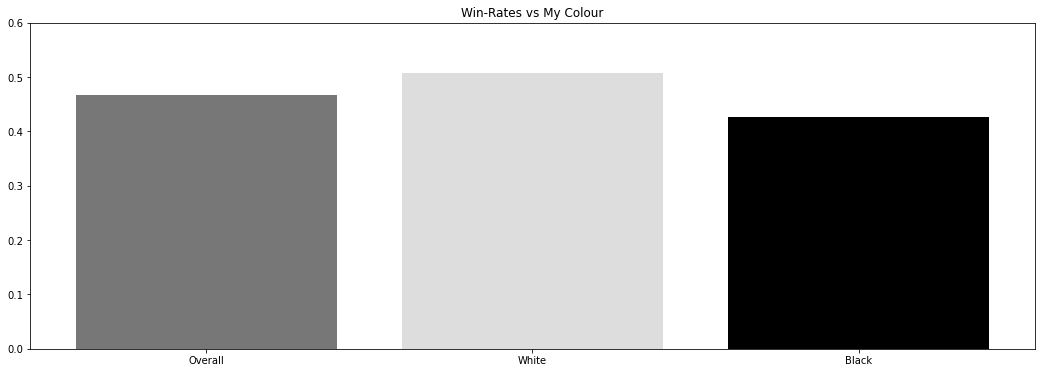

In [21]:
win_rates=[n_wins/n_games,n_white_wins/n_white_games,n_black_wins/n_black_games]
plt.bar(x=[0,1,2],height=win_rates,width=.8,tick_label=["Overall","White","Black"],color=["#777","#ddd","#000"])
plt.ylim(0,.6)
plt.title("Win-Rates vs My Colour")

### Rolling Win Rate

In [22]:
def calc_cum_wins_losses(df) -> (pd.Series,pd.Series):
    cum_wins=(df["my_colour"]==df["winner_colour"]).cumsum()
    cum_wins=cum_wins.reset_index(drop=True)
    cum_losses=pd.Series(range(1,cum_wins.shape[0]+1))-cum_wins
    return cum_wins,cum_losses

In [23]:
# all games
cum_wins_all,cum_losses_all=calc_cum_wins_losses(df)

# white games
cum_wins_white,cum_losses_white=calc_cum_wins_losses(df[df["my_colour"]=="white"])

# white games
cum_wins_black,cum_losses_black=calc_cum_wins_losses(df[df["my_colour"]=="black"])

In [24]:
cum_wins_white

0        1
1        1
2        1
3        1
4        1
      ... 
440    225
441    226
442    226
443    226
444    226
Length: 445, dtype: int32

In [25]:
def plot_cum_wins_losses(ax,wins,losses,legend=False,title=None):
    # plot data
    ax.plot(wins,c="green",label="Wins")
    ax.plot(losses,c="red",label="Losses")
    
    # text
    if legend: ax.legend()
    if title: ax.set_title(title)
    ax.set_xlabel("Games Played")
    ax.set_ylabel("Count")

    # emphasise difference
    ax.fill_between(x=range(len(wins)),y1=wins,y2=losses, where=(wins<=losses),interpolate=True,color='red',alpha=.2)
    ax.fill_between(x=range(len(wins)),y1=wins,y2=losses, where=(wins>=losses),interpolate=True,color='green',alpha=.2)
    
    # remove margins
    ax.margins(0)

In [26]:
def plot_net_cum_wins_losses(ax,wins,losses,legend=False,title=None):
    # calculate net
    net=wins-losses
    
    # split data into positive,negative and 0
    pos=np.ma.masked_where(net<0,net)
    neg=np.ma.masked_where(net>0,net)
    non=np.ma.masked_where(net!=0,net)
    
    # plot data (pos=green etc.)
    ax.plot(pos,c="green")
    ax.plot(neg,c="red")
    ax.plot(non,c="gray")
    
    # plot line to show net 0
    ax.axhline(y=0,c="black")
    
    # text
    if title: ax.set_title(title)
    ax.set_xlabel("Games Played")
    ax.set_ylabel("Net Count")
    
    # remove margins
    ax.margins(0)

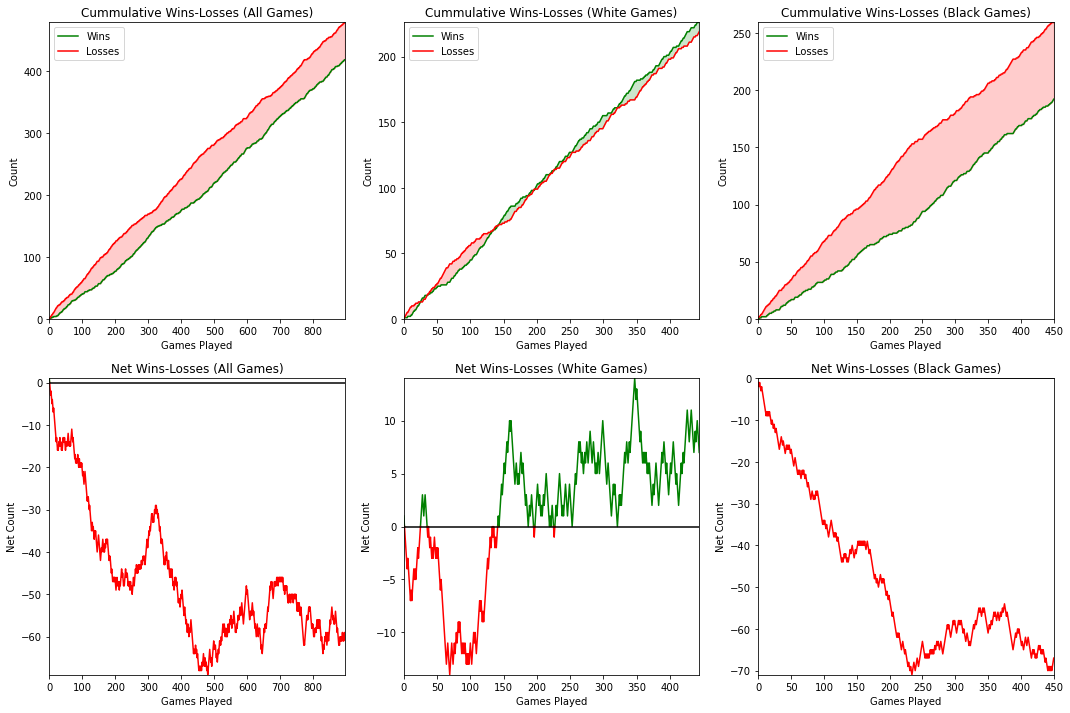

In [27]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(18,12))

plot_cum_wins_losses(ax[0,0],cum_wins_all,cum_losses_all,legend=True,title="Cummulative Wins-Losses (All Games)")
plot_cum_wins_losses(ax[0,1],cum_wins_white,cum_losses_white,legend=True,title="Cummulative Wins-Losses (White Games)")
plot_cum_wins_losses(ax[0,2],cum_wins_black,cum_losses_black,legend=True,title="Cummulative Wins-Losses (Black Games)")

plot_net_cum_wins_losses(ax[1,0],cum_wins_all,cum_losses_all,legend=True,title="Net Wins-Losses (All Games)")
plot_net_cum_wins_losses(ax[1,1],cum_wins_white,cum_losses_white,legend=True,title="Net Wins-Losses (White Games)")
plot_net_cum_wins_losses(ax[1,2],cum_wins_black,cum_losses_black,legend=True,title="Net Wins-Losses (Black Games)")

Basically, I am shite at playing as black